In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing
from tqdm import tqdm

from src.mlhgp import MLHGP
from src.imlhgp import IMLHGP
from src.nnpehgp import NNPEHGP
from src.rnhgp import RNHGP
from src import evaluator

## SUPPRESS ALL WARNINGS
import warnings
warnings.filterwarnings("ignore")

# Problem Definition

In [2]:
def f1(X, add_noise=False):
    target = X * np.sin(X) + np.sqrt(16*X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 1, size=target.shape)
    return target.squeeze()

f2 = np.cos
transform = np.exp

## Try and compare one pass

### Training data

In [23]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 10, size=50).reshape(-1, 1)
mean_train = f1(X_train, add_noise=False).reshape(-1,1)
scale_train = transform(f2(X_train))

np.random.seed(17)
y_train = np.random.normal(mean_train, scale_train)

### Testing Data

In [24]:
X_test = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)

# Compute loc and scale as functions of input X
mean_test = f1(X_test, add_noise=False).reshape(-1,1)
scale_test = transform(f2(X_test))

# Sample outputs Y from Gaussian Likelihood
y_test = np.random.normal(mean_test, scale_test)

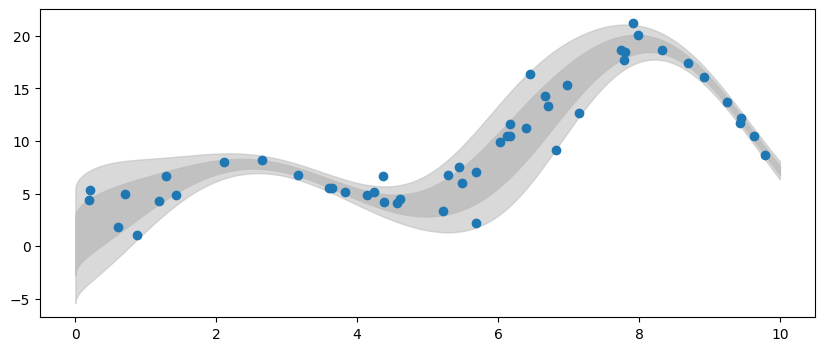

In [25]:
plt.figure(figsize=(10, 4))
x = X_test.squeeze()
for k in (1, 2):
    lb = (mean_test - k * scale_test).squeeze()
    ub = (mean_test + k * scale_test).squeeze()
    plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
plt.scatter(X_train, y_train)
plt.show()

### Normalize input feature

In [26]:
# Normalize X
normalizer = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

### Define models

In [27]:
# define the model
def hgp_constructor(X_train_norm, y_train, kernel, kernel_noise):
    hgps = [MLHGP,IMLHGP,NNPEHGP,RNHGP]
    trained_hgps = []

    for hgp in hgps:
        # Initialize models
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
        gp_noise = GaussianProcessRegressor(kernel=kernel_noise, n_restarts_optimizer=25)
        model_hgp = hgp(model=gp, model_noise=gp_noise)

        # fit the model
        model_hgp.fit(X_train_norm, y_train.flatten())
        trained_hgps.append(model_hgp)

    return trained_hgps

In [28]:
kernel = ConstantKernel(1.0) * RBF(length_scale=1e-1, length_scale_bounds=(1e-3, 2)) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-3, 1e2)
    )
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e-1, length_scale_bounds=(1e-3, 2)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-3, 1e2)
)
hgp = hgp_constructor(X_train_norm, y_train, kernel, kernel_noise)

In [29]:
# make a prediction 
model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "RNHGP"]
res_dict = {}
for idx,hgp_model in tqdm(enumerate(hgp)):
    subres_dict = {}
    Y_pred, Std_pred = hgp_model.predict(X_test_norm, return_std="multi")
    subres_dict["y_pred"] = Y_pred
    subres_dict["std_pred"] = Std_pred
    res_dict[model_name[idx]] = subres_dict

4it [00:00, 15.94it/s]


### Evaluation

#### Visual

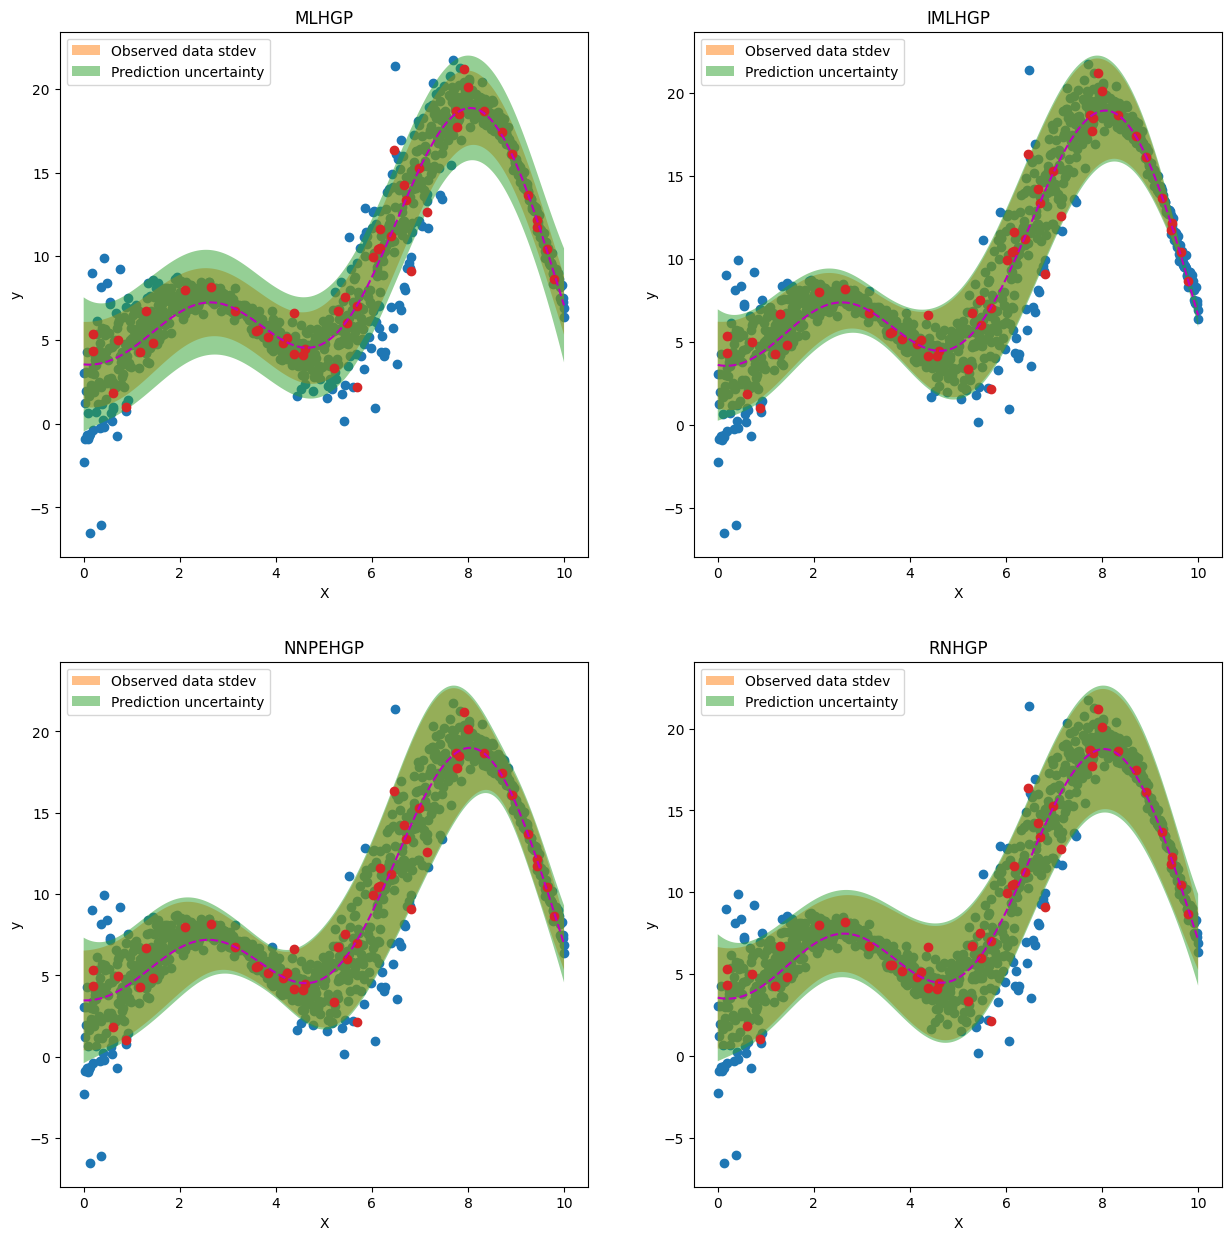

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
idx = 0
for ax in axs.flat:
    # Extract results
    name = model_name[idx]
    res = res_dict[name]
    y_pred = res["y_pred"]
    std_al, std_ep = res["std_pred"]
    std_tot = np.sqrt(std_al**2 + std_ep**2)

    ax.scatter(X_test,y_test)
    x = X_test.squeeze()
    ax.fill_between(
        X_test.ravel(),
        y_pred - 1.96 * (std_al),
        y_pred + 1.96 * (std_al),
        alpha=0.5,
        label=r"Observed data stdev",
    )
    ax.fill_between(
        X_test.ravel(),
        y_pred - 1.96 * std_tot,
        y_pred + 1.96 * std_tot,
        alpha=0.5,
        label=r"Prediction uncertainty",
    )
    ax.plot(X_test, y_pred, "--m")
    ax.scatter(X_train, y_train)
    ax.set_title(name)
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.legend()
    idx += 1

#### Quantitative

In [31]:
def score_eval(X_test, y_test_mean, y_test_std, y_pred, std_al, std_ep):

    # Compute average Wasserstein distance (Earth moving distance)
    d_wass_list = []
    for i,x in enumerate(X_test):
        # actual distribution
        act_dist = [y_test_mean[i,:], y_test_std[i,:]]
        pred_dist = [y_pred[i], std_al[i]]

        d_wass, dists, m2 = evaluator.wasserstein2(act_dist, pred_dist)
        d_wass_list.append(d_wass)
    
    avg_wass = np.mean(d_wass_list)

    # Compute SMSE of noise
    smse = evaluator.noise_smse(std_al, y_test_std)

    # Compute NLPD
    std_tot = np.sqrt(std_al**2 + std_ep**2)
    nlpd = evaluator.nlpd_loss(y_test_mean, y_pred, std_tot**2)

    return avg_wass, smse, nlpd

In [32]:
for name in model_name:
    res = res_dict[name]
    y_pred = res["y_pred"]
    std_al, std_ep = res["std_pred"]
    avg_wass, smse, nlpd = score_eval(X_test, mean_test, scale_test, y_pred, std_al, std_ep)
    print(name)
    print(f"Average Wasserstein: {avg_wass}, Noise SMSE: {smse}, NLPD: {nlpd}")

MLHGP
Average Wasserstein: 0.8177226134389195, Noise SMSE: 0.6736726814173193, NLPD: 14.18403805020604
IMLHGP
Average Wasserstein: 0.5894257069245437, Noise SMSE: 0.3861969102719867, NLPD: 31.267870843130904
NNPEHGP
Average Wasserstein: 0.651972086444612, Noise SMSE: 0.4244801562224458, NLPD: 20.243554819600995
RNHGP
Average Wasserstein: 0.9971392735013596, Noise SMSE: 0.9732016979118981, NLPD: 12.624512620362944


## Varying random seeds

In [13]:
def train_data_maker(seednum, size=25):
    rng = np.random.RandomState(seednum)
    X_train = rng.uniform(0, 10, size=size).reshape(-1, 1)
    mean_train = f1(X_train, add_noise=False).reshape(-1,1)
    scale_train = transform(f2(X_train))

    np.random.seed(seednum)
    y_train = np.random.normal(mean_train, scale_train)

    return X_train, y_train

In [14]:
def main(datasize, repeat=100):

    model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "RNHGP"]
    metrics_name = ["wasserstein", "smse", "nlpd", "model"]

    ## Initialize metrics dictionary
    model_scores = dict()
    for met in metrics_name:
        model_scores[met] = dict()
        for name in model_name:
            model_scores[met][name] = []
    
    model_scores["train_data"] = []

    for i in tqdm(range(repeat)):
        X_train, y_train = train_data_maker(seednum=i, size=datasize)
        train = {"x": X_train, "y": y_train}
        model_scores["train_data"].append(train)
        
        # Test data
        X_test = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)

        # Compute loc and scale as functions of input X
        mean_test = f1(X_test, add_noise=False).reshape(-1,1)
        scale_test = transform(f2(X_test))

        # Sample outputs Y from Gaussian Likelihood
        y_test = np.random.normal(mean_test, scale_test)
        
        # Normalize X
        normalizer = sklearn.preprocessing.StandardScaler().fit(X_train)
        X_train_norm = normalizer.transform(X_train)
        X_test_norm = normalizer.transform(X_test)

        # Train models
        kernel = ConstantKernel(1.0) * RBF(length_scale=1e-1, length_scale_bounds=(1e-3, 1)) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-3, 1e2)
        )
        kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e-1, length_scale_bounds=(1e-3, 1)) + WhiteKernel(
            noise_level=1, noise_level_bounds=(1e-3, 1e2)
        )
        hgp = hgp_constructor(X_train_norm, y_train, kernel, kernel_noise)

        # make a prediction 
        model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "RNHGP"]
        res_dict = {}
        for idx,hgp_model in enumerate(hgp):
            subres_dict = {}
            Y_pred, Std_pred = hgp_model.predict(X_test_norm, return_std="multi")
            subres_dict["y_pred"] = Y_pred
            subres_dict["std_pred"] = Std_pred
            res_dict[model_name[idx]] = subres_dict
            model_scores["model"][model_name[idx]].append(hgp_model)
        
        # Evaluate
        for name in model_name:
            res = res_dict[name]
            y_pred = res["y_pred"]
            std_al, std_ep = res["std_pred"]
            avg_wass, smse, nlpd = score_eval(X_test, mean_test, scale_test, y_pred, std_al, std_ep)
            model_scores["wasserstein"][name].append(avg_wass)
            model_scores["smse"][name].append(smse)
            model_scores["nlpd"][name].append(nlpd)
        
    return model_scores

In [15]:
model_scores = main(datasize=50, repeat=50)

100%|██████████| 50/50 [10:27<00:00, 12.54s/it]


In [16]:
np.argmax(model_scores["wasserstein"]["RNHGP"])

26

In [17]:
np.argmax(model_scores["nlpd"]["RNHGP"])

25

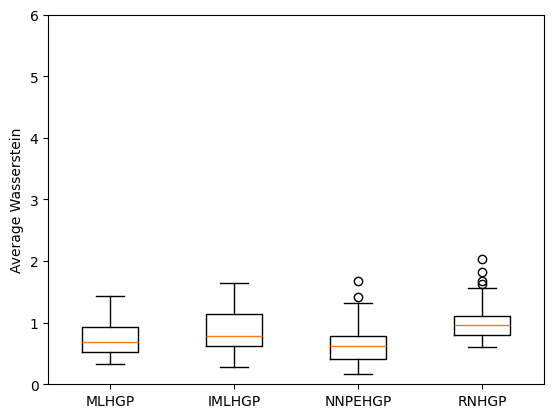

In [18]:
fig, ax = plt.subplots()
ax.boxplot(model_scores["wasserstein"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
ax.set_ylabel("Average Wasserstein")
plt.show()

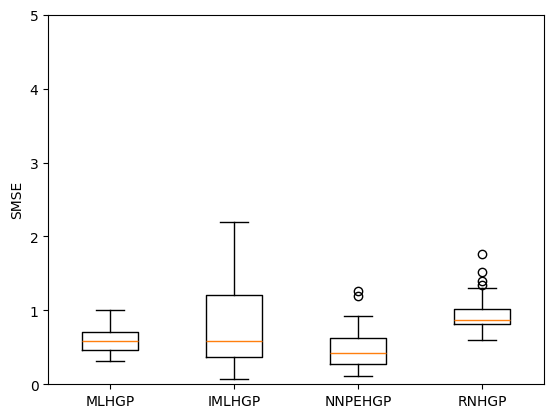

In [19]:
fig, ax = plt.subplots()
ax.boxplot(model_scores["smse"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
ax.set_ylabel("SMSE")
plt.show()

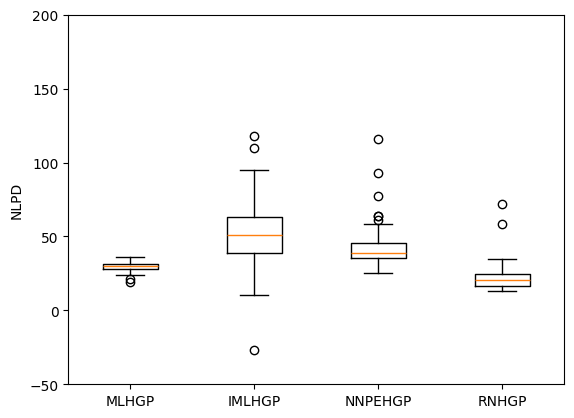

In [20]:
fig, ax = plt.subplots()
ax.boxplot(model_scores["nlpd"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
ax.set_ylabel("NLPD")
plt.show()

In [21]:
worst_nlpd_rnhgp = model_scores["model"]["RNHGP"][np.argmax(model_scores["nlpd"]["RNHGP"])]
data_worst_nlpd = model_scores["train_data"][np.argmax(model_scores["nlpd"]["RNHGP"])]

worst_wass_rnhgp = model_scores["model"]["RNHGP"][np.argmax(model_scores["wasserstein"]["RNHGP"])]
data_worst_wass = model_scores["train_data"][np.argmax(model_scores["wasserstein"]["RNHGP"])]

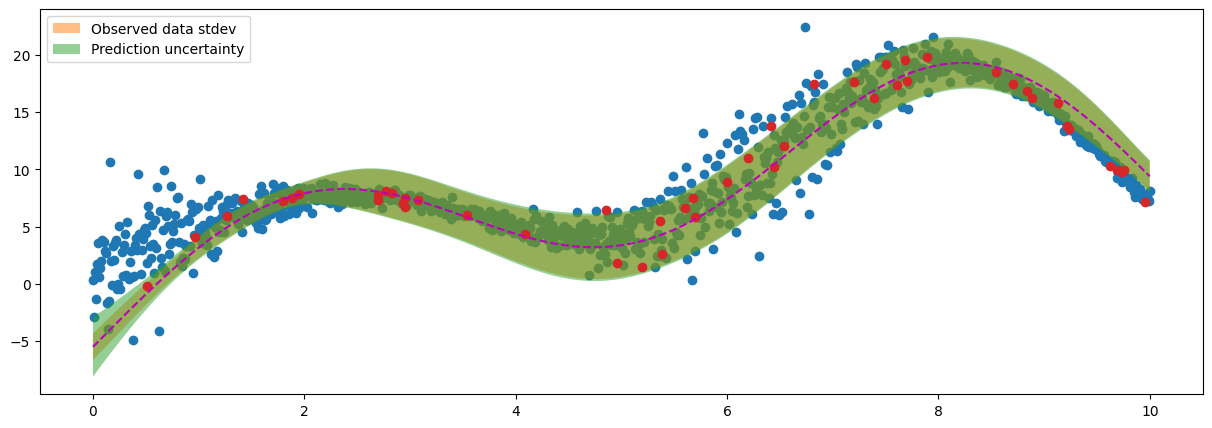

In [22]:
Y_pred, Std_pred = worst_wass_rnhgp.predict(X_test_norm, return_std="multi")
std_al, std_ep = Std_pred
std_tot = np.sqrt(std_al**2 + std_ep**2)

plt.figure(figsize=(15, 5))
plt.scatter(X_test,y_test)
x = X_test.squeeze()
plt.fill_between(
    X_test.ravel(),
    Y_pred - 1.96 * (std_al),
    Y_pred + 1.96 * (std_al),
    alpha=0.5,
    label=r"Observed data stdev",
)
plt.fill_between(
    X_test.ravel(),
    Y_pred - 1.96 * std_tot,
    Y_pred + 1.96 * std_tot,
    alpha=0.5,
    label=r"Prediction uncertainty",
)
plt.plot(X_test, Y_pred, "--m")
plt.scatter(data_worst_wass["x"], data_worst_wass["y"])
plt.legend()